In [1]:
%matplotlib inline

import os
import random
import fnmatch
import datetime
import pickle
import sys
import glob
import h5py
import numpy as np

import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

Using TensorFlow backend.
tf.__version__: 2.1.0
keras.__version__: 2.3.1


In [2]:
model_output_dir = './nvidia_model'
datasetDirTrain = '/media/zx/eff30071-6ef0-4269-8d39-989b25203d99/gft_deep_workspace/dataset/train/'
datasetDirVal = '/media/zx/eff30071-6ef0-4269-8d39-989b25203d99/gft_deep_workspace/dataset/val/'
datasetFilesTrain = glob.glob(datasetDirTrain+'*.h5')
datasetFilesVal = glob.glob(datasetDirVal+'*.h5')

8 /media/zx/eff30071-6ef0-4269-8d39-989b25203d99/gft_deep_workspace/dataset/train/carla-dataset-2021-03-14_5.h5 2
<HDF5 file "carla-dataset-2021-03-14_5.h5" (mode r)>
KeysView(<HDF5 file "carla-dataset-2021-03-14_5.h5" (mode r)>)
(1201, 160, 384, 3)
(1201,)


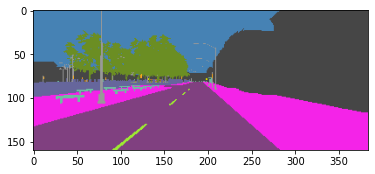

In [11]:
print(len(datasetFilesTrain), datasetFilesTrain[0], len(datasetFilesVal))

dataset = h5py.File(datasetFilesTrain[0], 'r')

print(dataset)
print(dataset.keys())
print(dataset['rgb'].shape)
print(dataset['measurements'].shape)

ind = 22
x = dataset['rgb'][ind]
plt.imshow(x)
dataset.close()

In [28]:
images = []
steering_angles = []
batch_data_siz = 8

for idData in range(0,batch_data_siz):
    try:
        dataset = h5py.File(datasetFilesTrain[idData], 'r')
        for idx in range(0,200):
            steering_angles.append(dataset['measurements'][idx][0])
            images.append(dataset['rgb'][idx])
        dataset.close()
    except: 
        print(datasetFilesTrain[idData])

df = pd.DataFrame()
df['ImagePath'] = images
df['Angle'] = steering_angles

,ImagePath,Angle
0,"[[[70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [7...",0.0000
1,"[[[70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [7...",0.0000
2,"[[[70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [7...",0.0000
3,"[[[70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [7...",0.0000
4,"[[[70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [7...",-0.1000
...,...,...
1595,"[[[70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [7...",-0.0010
1596,"[[[70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [7...",-0.0010
1597,"[[[70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [7...",-0.0010
1598,"[[[70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [70, 130, 180], [7...",-0.0006


(array([16.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 488.0000, 144.0000,
        528.0000, 424.0000]),
 array([-0.1000, -0.0958, -0.0916, -0.0874, -0.0832, -0.0790, -0.0748,
        -0.0706, -0.0664, -0.0622, -0.0580, -0.0538, -0.0496, -0.0454,
        -0.0412, -0.0370, -0.0328, -0.0286, -0.0244, -0.0202, -0.0160,
        -0.0118, -0.0076, -0.0034, 0.0008, 0.0050]),
 <BarContainer object of 25 artists>)

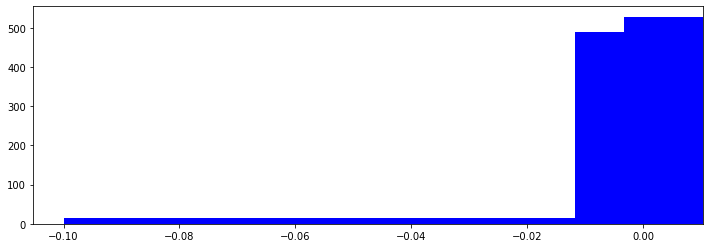

In [29]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 1280
Validation data: 320


Text(0.5, 1.0, 'Validation Data')

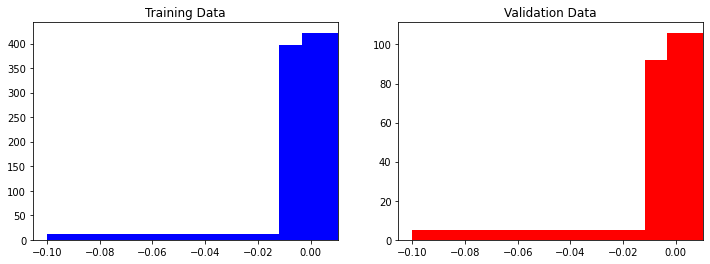

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split( images, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

Text(0.5, 1.0, 'zoomed')

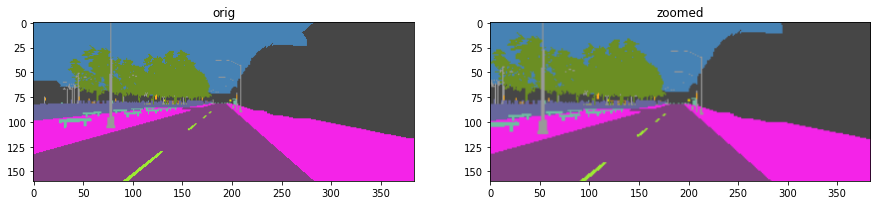

In [31]:
image_index = 27

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

image_orig = images[image_index]
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")

Text(0.5, 1.0, 'panned')

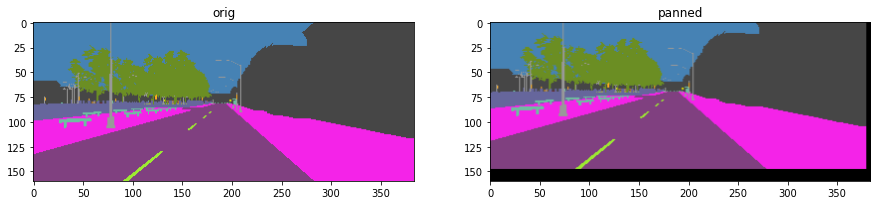

In [32]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = images[image_index]
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")

Text(0.5, 1.0, 'brightness adjusted')

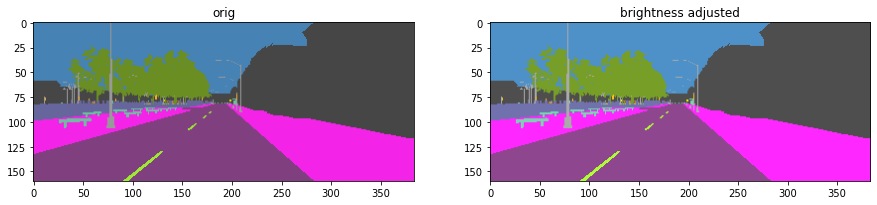

In [33]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = images[image_index]
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

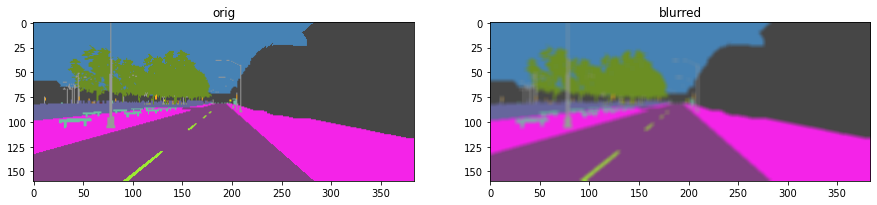

In [34]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = images[image_index]
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=-0.0084')

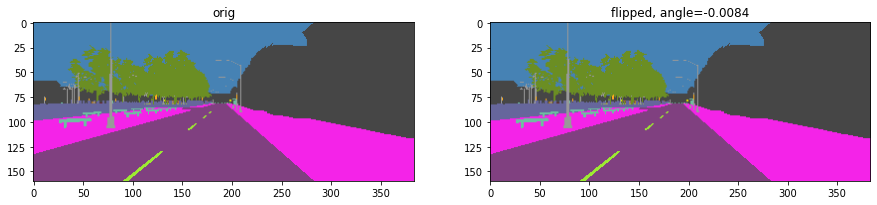

In [35]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = images[image_index]
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

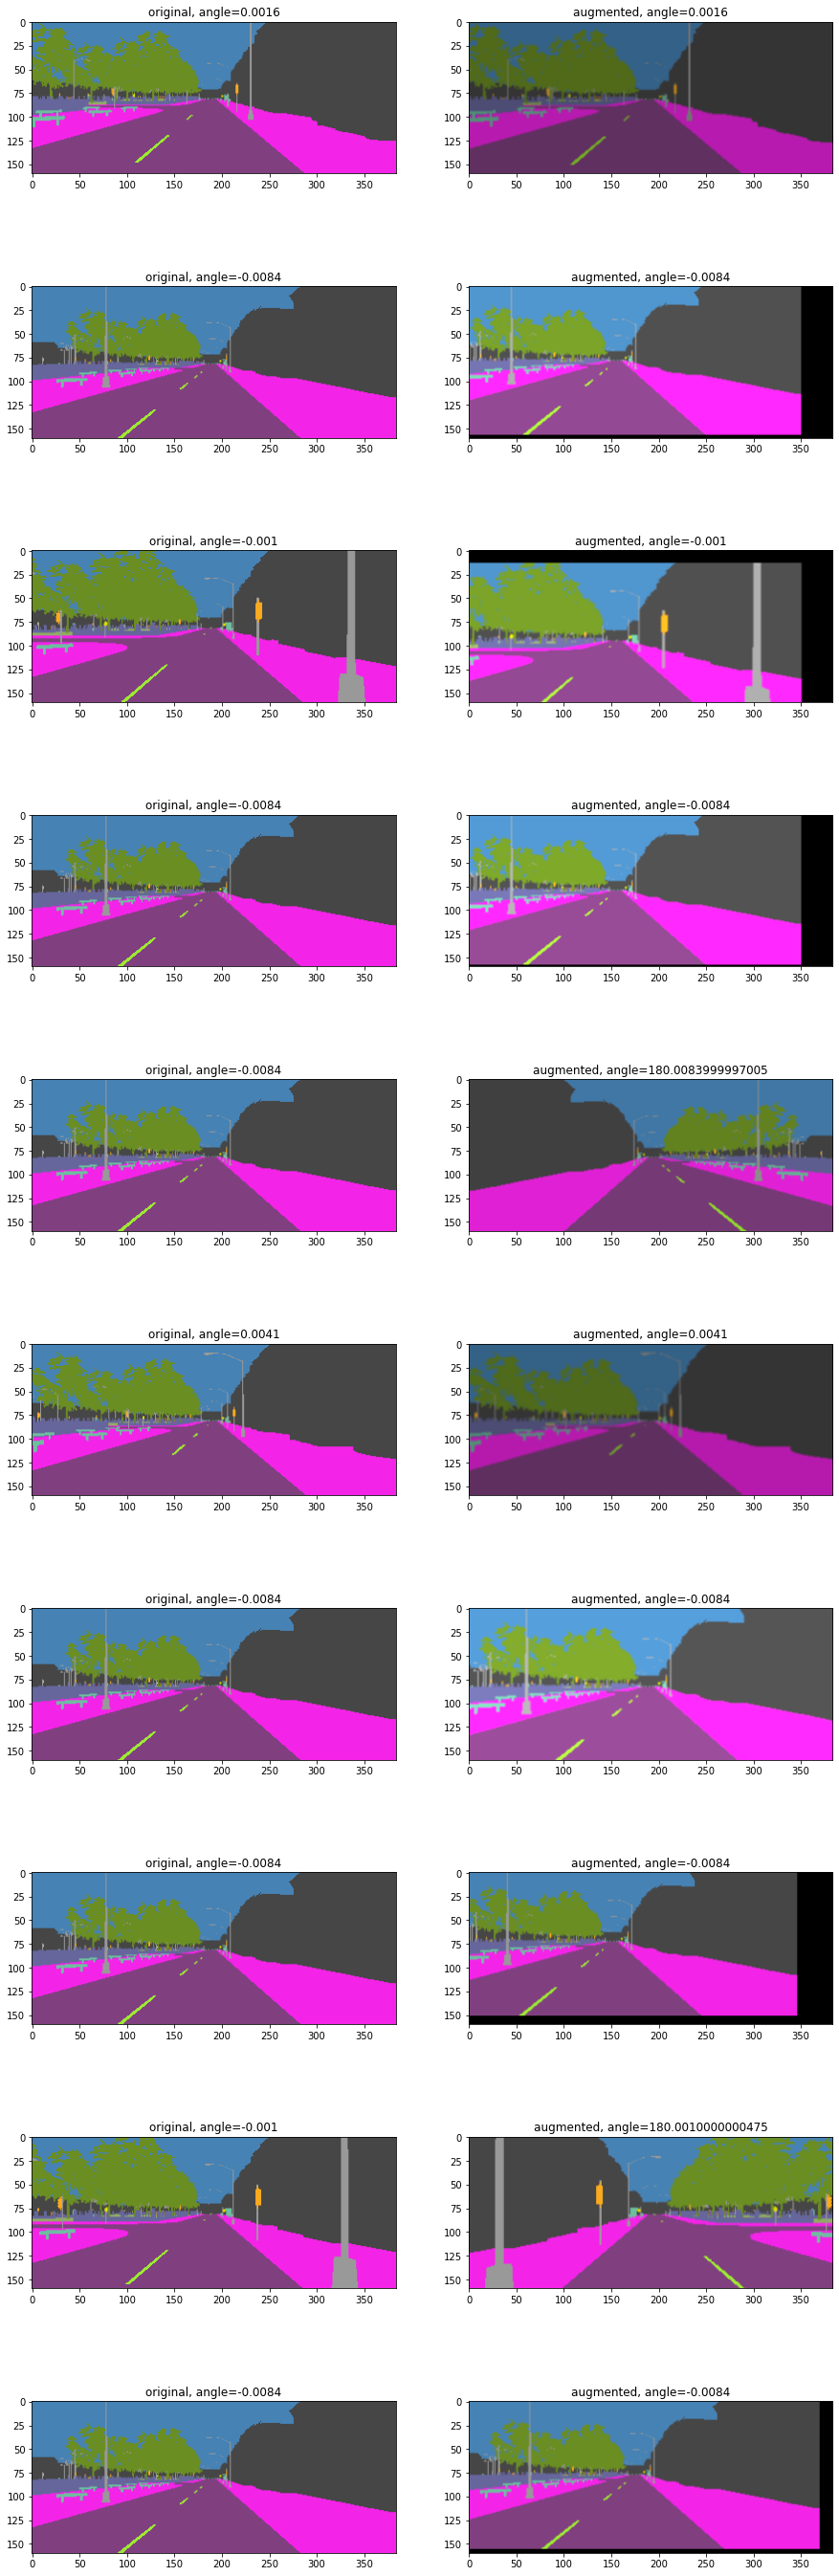

In [36]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(images) - 1)
    steering_angle_orig = steering_angles[rand_index]
    
    image_orig = images[rand_index]
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)

Text(0.5, 1.0, 'processed')

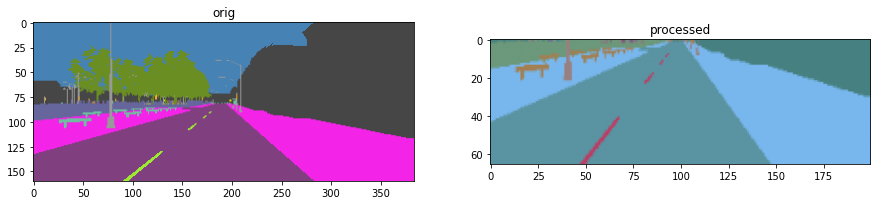

In [37]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  
    #image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66))
    image = image / 255 
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = images[image_index]
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [38]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [39]:
model = nvidia_model()
plot_model(model,to_file='nvidia.png',show_shapes=True)
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

In [40]:
def image_data_generator(images, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(images) - 1)
            image = images[random_index]
            steering_angle = steering_angles[random_index]
            if is_training:
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

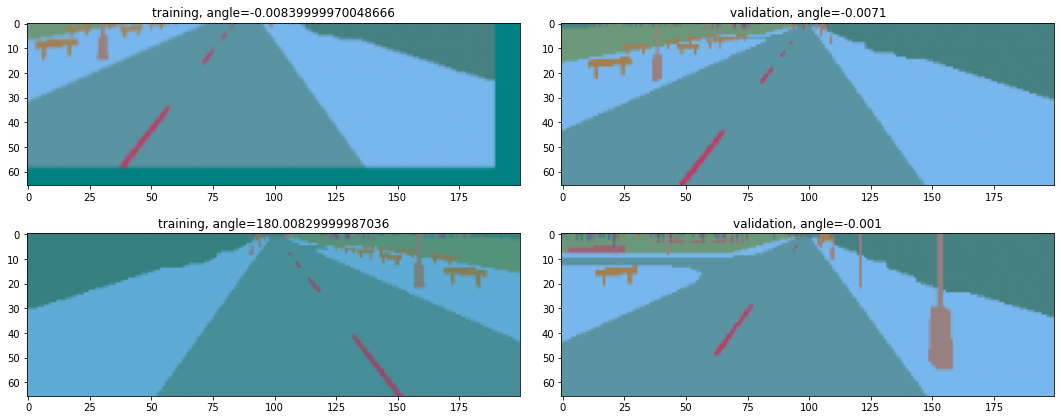

In [41]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [42]:
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root

In [44]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=200,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

och 115/200
299/300 [============================>.] - ETA: 0s - loss: 0.6973
Epoch 00115: val_loss did not improve from 0.00017
300/300 [==============================] - 53s 175ms/step - loss: 0.6961 - val_loss: 2.3663e-04
Epoch 116/200
299/300 [============================>.] - ETA: 0s - loss: 0.6880
Epoch 00116: val_loss did not improve from 0.00017
300/300 [==============================] - 53s 178ms/step - loss: 0.6864 - val_loss: 1.9086e-04
Epoch 117/200
299/300 [============================>.] - ETA: 0s - loss: 0.3205
Epoch 00117: val_loss did not improve from 0.00017
300/300 [==============================] - 53s 177ms/step - loss: 0.3202 - val_loss: 1.9113e-04
Epoch 118/200
299/300 [============================>.] - ETA: 0s - loss: 0.2426
Epoch 00118: val_loss did not improve from 0.00017
300/300 [==============================] - 54s 179ms/step - loss: 0.2425 - val_loss: 1.8393e-04
Epoch 119/200
299/300 [============================>.] - ETA: 0s - loss: 0.2120
Epoch 00119: v

In [45]:
history.history

{'loss': [15.420720866521199,
  9.92705322901408,
  8.580383526484171,
  7.167508986790975,
  27.118785179456076,
  12.069807962576549,
  5.1804426805178325,
  4.737201183636984,
  8.345666882197062,
  16.666104301611583,
  291.8728133090337,
  7.861868960062663,
  7.1489106186230975,
  5.002238815625509,
  11.575741633574168,
  6.9440426007906595,
  4.564375791549683,
  4.801480578581492,
  4.257126901944479,
  4.585700394709905,
  4.202592535018921,
  3.8312169726689658,
  3.9959297355016075,
  3.759384570121765,
  3.6160186632474263,
  4.675376850763957,
  17.03621465841929,
  3.7761062026023864,
  3.5693446588516236,
  3.7868155165513357,
  4.923619770208995,
  3.6034052670001984,
  149.62877259492873,
  14.146114124457041,
  4.427914078235626,
  4.328145468235016,
  3.741350441376368,
  3.996141706307729,
  4.341698506275812,
  3.8038863134384155,
  4.073102009296417,
  3.662822642326355,
  4.972142895857493,
  36.9182936668396,
  3.620889460245768,
  4.502328578233719,
  4.869172

In [47]:
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

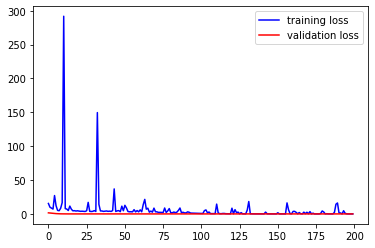

In [48]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [49]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_final.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

mse       = 0.00011
r_squared = -0.02%



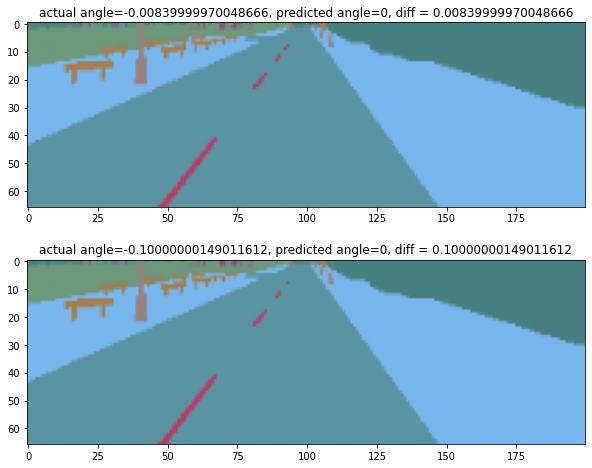

In [50]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")